# Retail KPI Business Intelligence Framework

## Project Objective

This project simulates a Business Intelligence dashboard using Python.

The goal is to:
- Compute core retail KPIs
- Analyze revenue trends
- Evaluate customer activity
- Identify churn risk patterns
- Generate executive-ready business insights


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:
df = pd.read_excel("Online_Retail.xlsx", sheet_name=0)

df = df.dropna(subset=["Customer ID"])
df = df[df["Quantity"] > 0]

df["Revenue"] = df["Quantity"] * df["Price"]
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


## Executive KPI Overview

This section presents the core retail performance indicators typically displayed in a Business Intelligence dashboard.


In [4]:
# Basic KPI calculations
total_revenue = df["Revenue"].sum()
total_orders = df["Invoice"].nunique()
total_customers = df["Customer ID"].nunique()

aov = total_revenue / total_orders  # Average Order Value

kpi = pd.DataFrame({
    "KPI": ["Total Revenue", "Total Orders", "Total Customers", "Average Order Value (AOV)"],
    "Value": [total_revenue, total_orders, total_customers, aov]
})

kpi


,KPI,Value
0,Total Revenue,8.832003e+06
1,Total Orders,1.921500e+04
2,Total Customers,4.314000e+03
3,Average Order Value (AOV),4.596411e+02


In [5]:
# Create Year-Month column
df["YearMonth"] = df["InvoiceDate"].dt.to_period("M")

# Monthly revenue
monthly_revenue = (
    df.groupby("YearMonth")["Revenue"]
    .sum()
    .reset_index()
)

monthly_revenue["YearMonth"] = monthly_revenue["YearMonth"].astype(str)

monthly_revenue.head()


,YearMonth,Revenue
0,2009-12,686654.160
1,2010-01,557319.062
2,2010-02,506371.066
3,2010-03,699608.991
4,2010-04,594609.192


In [6]:
monthly_revenue["MoM_Growth_%"] = monthly_revenue["Revenue"].pct_change() * 100

monthly_revenue


,YearMonth,Revenue,MoM_Growth_%
0,2009-12,686654.160,NaN
1,2010-01,557319.062,-18.835552
2,2010-02,506371.066,-9.141621
3,2010-03,699608.991,38.161328
4,2010-04,594609.192,-15.008355
5,2010-05,599985.790,0.904224
6,2010-06,639066.580,6.513619
7,2010-07,591636.740,-7.421737
8,2010-08,604242.650,2.130684
9,2010-09,831615.001,37.629312


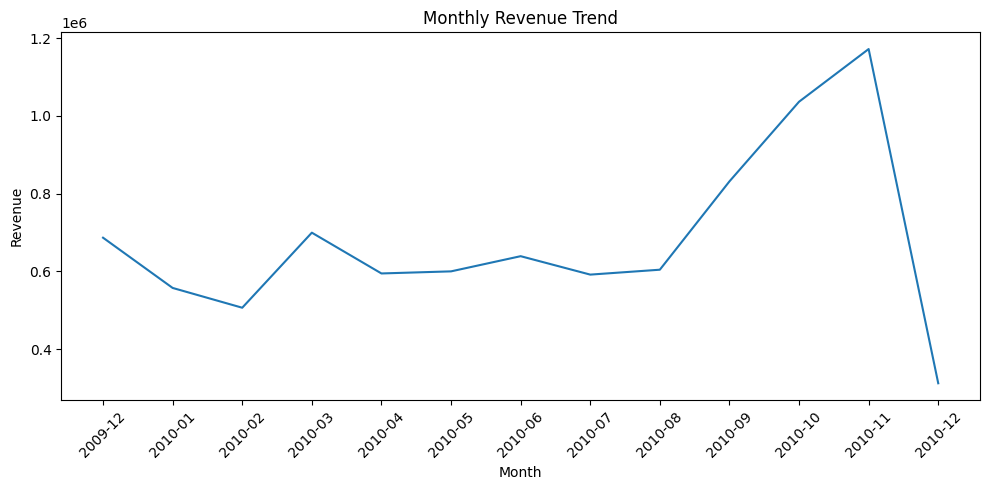

In [7]:
plt.figure(figsize=(10,5))
plt.plot(monthly_revenue["YearMonth"], monthly_revenue["Revenue"])
plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()


In [8]:
# Reference date (latest transaction date in the dataset)

reference_date = df["InvoiceDate"].max()

# Recency calculation (days since the customer's last purchase)

recency = (
    df.groupby("Customer ID")["InvoiceDate"]
    .max()
    .reset_index()
)

recency["Recency_Days"] = (reference_date - recency["InvoiceDate"]).dt.days

recency.head()


,Customer ID,InvoiceDate,Recency_Days
0,12346.0,2010-06-28 13:53:00,164
1,12347.0,2010-12-07 14:57:00,2
2,12348.0,2010-09-27 14:59:00,73
3,12349.0,2010-10-28 08:23:00,42
4,12351.0,2010-11-29 15:23:00,10


In [9]:
def segment_customer(days):
    if days <= 30:
        return "Active"
    elif days <= 90:
        return "At Risk"
    else:
        return "Lost"

recency["Segment"] = recency["Recency_Days"].apply(segment_customer)

recency.head()


,Customer ID,InvoiceDate,Recency_Days,Segment
0,12346.0,2010-06-28 13:53:00,164,Lost
1,12347.0,2010-12-07 14:57:00,2,Active
2,12348.0,2010-09-27 14:59:00,73,At Risk
3,12349.0,2010-10-28 08:23:00,42,At Risk
4,12351.0,2010-11-29 15:23:00,10,Active


In [10]:
segment_counts = recency["Segment"].value_counts()

segment_counts


Segment
Active     1616
Lost       1429
At Risk    1269
Name: count, dtype: int64

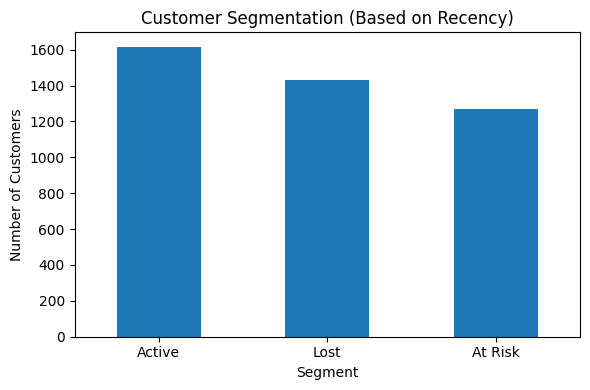

In [11]:
plt.figure(figsize=(6,4))
segment_counts.plot(kind="bar")
plt.title("Customer Segmentation (Based on Recency)")
plt.ylabel("Number of Customers")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [12]:
df_seg = df.merge(recency[["Customer ID", "Segment"]], on="Customer ID", how="left")
df_seg.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue,YearMonth,Segment
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009-12,Lost
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12,Lost
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12,Lost
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009-12,Lost
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009-12,Lost


## Revenue & Activity by Customer Segment

This section evaluates how different customer segments contribute to overall revenue and order volume.


In [13]:
segment_kpi = (
    df_seg.groupby("Segment")
    .agg(
        Customers=("Customer ID", "nunique"),
        Orders=("Invoice", "nunique"),
        Revenue=("Revenue", "sum"),
        Avg_Order_Value=("Revenue", lambda x: x.sum() / df_seg.loc[x.index, "Invoice"].nunique())
    )
    .reset_index()
)

segment_kpi


,Segment,Customers,Orders,Revenue,Avg_Order_Value
0,Active,1616,12090,5991272.877,495.556069
1,At Risk,1269,4172,1761890.023,422.313045
2,Lost,1429,2953,1078840.374,365.337072


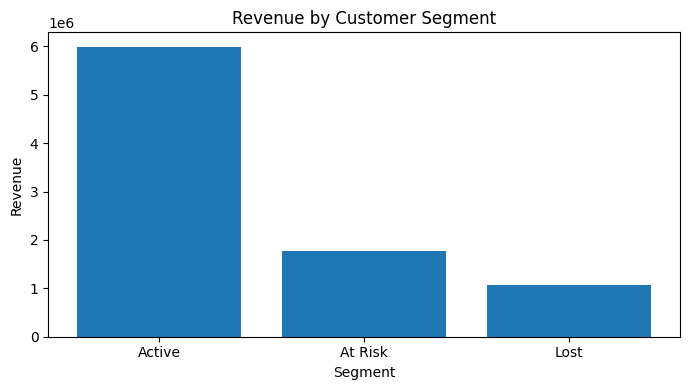

In [14]:
plt.figure(figsize=(7,4))
plt.bar(segment_kpi["Segment"], segment_kpi["Revenue"])
plt.title("Revenue by Customer Segment")
plt.xlabel("Segment")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()


## Geographic Revenue Analysis

This analysis identifies the top-performing countries and highlights potential market opportunities.


In [15]:
country_revenue = (
    df.groupby("Country")["Revenue"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

country_revenue.head(10)


,Country,Revenue
0,United Kingdom,7414755.963
1,EIRE,356085.210
2,Netherlands,268786.000
3,Germany,202395.321
4,France,146215.420
5,Sweden,53171.390
6,Denmark,50906.850
7,Spain,47601.420
8,Switzerland,43921.390
9,Australia,31446.800


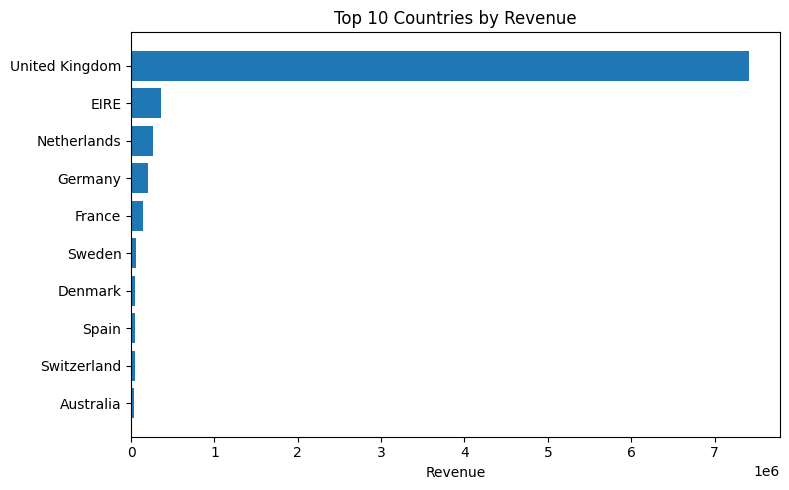

In [16]:
top_10_countries = country_revenue.head(10)

plt.figure(figsize=(8,5))
plt.barh(top_10_countries["Country"], top_10_countries["Revenue"])
plt.gca().invert_yaxis()
plt.title("Top 10 Countries by Revenue")
plt.xlabel("Revenue")
plt.tight_layout()
plt.show()


In [17]:
# First purchase date for each customer

df["InvoiceMonth"] = df["InvoiceDate"].dt.to_period("M")

cohort = df.groupby("Customer ID")["InvoiceMonth"].min().reset_index()
cohort.columns = ["Customer ID", "CohortMonth"]

df = df.merge(cohort, on="Customer ID")
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue,YearMonth,InvoiceMonth,CohortMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009-12,2009-12,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12,2009-12,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12,2009-12,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009-12,2009-12,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009-12,2009-12,2009-12


## Customer Retention Cohort Analysis

This cohort analysis evaluates customer retention over time based on their first purchase month.

It helps identify:
- Early churn patterns
- Long-term loyalty trends
- Retention drop-off points

Understanding retention behavior is critical for improving customer lifetime value (CLV).



In [18]:
df["CohortIndex"] = (
    (df["InvoiceMonth"].dt.year - df["CohortMonth"].dt.year) * 12 +
    (df["InvoiceMonth"].dt.month - df["CohortMonth"].dt.month)
)


In [19]:
cohort_data = (
    df.groupby(["CohortMonth", "CohortIndex"])["Customer ID"]
    .nunique()
    .reset_index()
)

cohort_pivot = cohort_data.pivot(
    index="CohortMonth",
    columns="CohortIndex",
    values="Customer ID"
)

cohort_pivot.head()


CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2009-12,955.0,337.0,319.0,406.0,363.0,343.0,360.0,327.0,321.0,346.0,403.0,473.0,237.0
2010-01,383.0,79.0,119.0,117.0,101.0,115.0,99.0,88.0,107.0,122.0,116.0,38.0,NaN
2010-02,376.0,89.0,84.0,109.0,92.0,75.0,72.0,107.0,95.0,103.0,27.0,NaN,NaN
2010-03,443.0,84.0,102.0,107.0,103.0,90.0,109.0,134.0,122.0,35.0,NaN,NaN,NaN
2010-04,294.0,57.0,57.0,48.0,54.0,66.0,81.0,77.0,20.0,NaN,NaN,NaN,NaN


In [20]:
cohort_size = cohort_pivot.iloc[:,0]

retention = cohort_pivot.divide(cohort_size, axis=0)

retention.round(3)


CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2009-12,1.0,0.353,0.334,0.425,0.380,0.359,0.377,0.342,0.336,0.362,0.422,0.495,0.248
2010-01,1.0,0.206,0.311,0.305,0.264,0.300,0.258,0.230,0.279,0.319,0.303,0.099,NaN
2010-02,1.0,0.237,0.223,0.290,0.245,0.199,0.191,0.285,0.253,0.274,0.072,NaN,NaN
2010-03,1.0,0.190,0.230,0.242,0.233,0.203,0.246,0.302,0.275,0.079,NaN,NaN,NaN
2010-04,1.0,0.194,0.194,0.163,0.184,0.224,0.276,0.262,0.068,NaN,NaN,NaN,NaN
2010-05,1.0,0.157,0.169,0.173,0.177,0.256,0.213,0.079,NaN,NaN,NaN,NaN,NaN
2010-06,1.0,0.174,0.189,0.204,0.230,0.285,0.067,NaN,NaN,NaN,NaN,NaN,NaN
2010-07,1.0,0.156,0.183,0.296,0.290,0.102,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,1.0,0.204,0.296,0.321,0.117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Executive Summary

This project simulates a Business Intelligence dashboard using Python.

Key findings:
- Revenue concentration is driven by a limited number of high-performing countries.
- A small percentage of customers generate a disproportionate share of total revenue.
- Early churn (Month 1) represents the highest retention risk.
- Segment-based strategies can improve marketing efficiency.

This analysis demonstrates the ability to translate raw transactional data into decision-ready insights.
